In [2]:
import numpy as np
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [45]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360
num_epochs = 20
encoder_ver = f'{n_hidden}h{num_epochs}e'

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')
y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

(17609,)


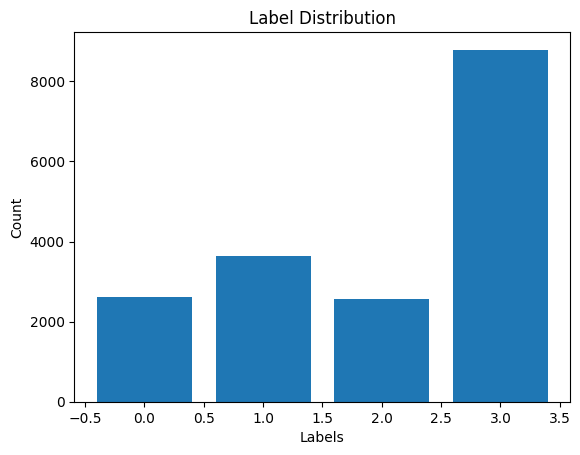

In [46]:
# Check Dataset
labels = np.load('Generated_Datasets/train_labels_noMag3w05s_Larm.npy')
print(labels.shape)
unique_labels, label_counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, label_counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [47]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_ver):
        self.train_X = np.array(np.load(f'Generated_Datasets/train_data_noMag{dataset_ver}.npy'))
        self.train_y = np.array(np.load(f'Generated_Datasets/train_labels_noMag{dataset_ver}.npy'))

    def __len__(self):
        return len(self.train_X)
    
    def __getitem__(self, idx):
        X = torch.from_numpy(self.train_X[idx]).float()
        y = torch.from_numpy(np.asarray(self.train_y[idx])).float()
        return X, y

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_ver):
        self.train_X = np.array(np.load(f'Generated_Datasets/test_data_noMag{dataset_ver}.npy'))
        self.train_y = np.array(np.load(f'Generated_Datasets/test_labels_noMag{dataset_ver}.npy'))

    def __len__(self):
        return len(self.train_X)
    
    def __getitem__(self, idx):
        X = torch.from_numpy(self.train_X[idx]).float()
        y = torch.from_numpy(np.asarray(self.train_y[idx])).float()
        return X, y

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size*2, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        return encoded_x


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size*2, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=output_size, batch_first=True)

    def forward(self, x):
        x = x.repeat(60, 1, 1)
        x = x.reshape(x.shape[1], 60, self.hidden_size)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size).to(device)
        self.decoder = Decoder(hidden_size, in_out_size).to(device)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
autoencoder = Autoencoder(n_input, n_hidden).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(10, 720, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 720, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (LSTM2): LSTM(720, 10, batch_first=True)
  )
  (loss): CrossEntropyLoss()
)


In [43]:
# Bidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size//2, batch_first=True, bidirectional=True)

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        print("Final Encoded: ", encoded_x.shape)
        return encoded_x


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=output_size//2, batch_first=True, bidirectional=True)

    def forward(self, x):
        print("Decoder x: ", x.shape)
        x = x.repeat(60, 1, 1)
        x = x.reshape(x.shape[1], 60, self.hidden_size)
        print("Reshaped Decoder x: ", x.shape)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size).to(device)
        self.decoder = Decoder(hidden_size, in_out_size).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [71]:
# Bidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, dropout, bidirectional):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=layer_size,
                            dropout=dropout,
                            batch_first=True, 
                            bidirectional=bidirectional)
    def forward(self, x):
        x, (encoded_x, _) = self.LSTM(x)    # (layers, batch_size, hidden_size)
        # print("Encoded: ", encoded_x.shape)
        encoded_x = encoded_x[-1, :, :].view(-1, self.hidden_size)
        # encoded_x = encoded_x[-1, :, :].unsqueeze(0)     
        # print("Final Encoded: ", encoded_x.shape)
        return encoded_x


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, layer_size, dropout, bidirectional):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.layer_size = layer_size
        self.LSTM = nn.LSTM(input_size=hidden_size, 
                    hidden_size=hidden_size, 
                    num_layers=layer_size,
                    dropout=dropout,
                    batch_first=True, 
                    bidirectional=bidirectional)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # print("Decoder x: ", x.shape)
        x = x.repeat(60, 1, 1)
        x = x.reshape(x.shape[1], 60, self.hidden_size)
        x, (_, _) = self.LSTM(x)
        # print(x.shape, self.hidden_size)
        return x

class LSTM(nn.Module):
    def __init__(self,  input_size, hidden_size, layer_size, dropout, bidirectional=True):
        super(LSTM, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, layer_size, dropout, bidirectional).to(device)
        self.decoder = Decoder(hidden_size, input_size, layer_size, dropout, bidirectional).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [49]:
# RNN
class DANA(nn.Module):
    def __init__(self, inp_shape, out_shape):
        super(DANA, self).__init__()
        nb_filters = 64
        drp_out_dns = 0.5
        nb_dense = 512
        nb_dropout = 128

        self.conv = nn.Conv1d(inp_shape, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(nb_filters, nb_dense, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(nb_dense*2, nb_dropout)
        self.dropout = nn.Dropout(drp_out_dns)
        self.fc2 = nn.Linear(nb_dropout, out_shape)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        # print("CONV:", x.shape)
        x = x.permute(0, 2, 1)
        # print(x.shape)
        x, _ = self.lstm(x) # lstm = (batch, seq length, input_size)
        x = x[:, -1]
        # print("LSTM:",x.shape)
        x = self.fc1(x)
        # print("Linear1:",x.shape)
        x = self.dropout(x)
        x = self.fc2(x)
        # print("Linear2:",x.shape)

        return x

autoencoder = DANA(n_input, n_input).to(device)
print(autoencoder)

DANA(
  (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (lstm): LSTM(64, 512, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
  (loss): MSELoss()
)


In [50]:
### Train AutoEncoder ###
train_dataset = TrainDataset(dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

### Define Model ###
# autoencoder = Autoencoder(n_input, n_hidden).to(device)
# autoencoder = LSTM(n_input, n_hidden, 3, 0.5, True)
autoencoder = DANA(n_input, n_input).to(device)
print(autoencoder)


optimizer = optim.Adam(autoencoder.parameters(),
                        lr=1e-3,
                        betas=(0.9, 0.999),
                        eps=1e-8)
optimizer.zero_grad()

best_loss = np.inf
train_losses = []

for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch+1}...')
    for batch in train_dataloader:
        X_batch, y_batch = batch
        X = X_batch.to(device)
        # X = X.permute(0, 2, 1)
        # print("Input:", X.shape)
        y = y_batch.to(device).reshape(-1, 1)

        pred = autoencoder(X)
        # print("Pred:", pred.shape)
        loss_value = autoencoder.loss(pred, X.permute(1,0,2))

        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_losses.append(loss_value.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_value.item():.4f}')
    
    if loss_value.item() < best_loss:
        best_loss = loss_value.item()

        # Save Encoder
        # torch.save(autoencoder.encoder, f'ML_Models/{dataset_ver}_{encoder_ver}_encoder.pt')
        # Save Full Autoencoder
        torch.save(autoencoder, f'ML_Models/{dataset_ver}_{encoder_ver}_DANA.pt')


DANA(
  (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (lstm): LSTM(64, 512, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
  (loss): MSELoss()
)
Starting Epoch 1...


c:\Users\BLOOM\anaconda3\envs\cv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([60, 16, 9])) that is different to the input size (torch.Size([16, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\BLOOM\anaconda3\envs\cv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([60, 9, 9])) that is different to the input size (torch.Size([9, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Training Loss: 0.0308
Starting Epoch 2...
Epoch [2/20], Training Loss: 0.0453
Starting Epoch 3...
Epoch [3/20], Training Loss: 0.0251
Starting Epoch 4...
Epoch [4/20], Training Loss: 0.0280
Starting Epoch 5...
Epoch [5/20], Training Loss: 0.0289
Starting Epoch 6...
Epoch [6/20], Training Loss: 0.0447
Starting Epoch 7...
Epoch [7/20], Training Loss: 0.0217
Starting Epoch 8...
Epoch [8/20], Training Loss: 0.0409
Starting Epoch 9...
Epoch [9/20], Training Loss: 0.0259
Starting Epoch 10...
Epoch [10/20], Training Loss: 0.0360
Starting Epoch 11...
Epoch [11/20], Training Loss: 0.0396
Starting Epoch 12...
Epoch [12/20], Training Loss: 0.0424
Starting Epoch 13...
Epoch [13/20], Training Loss: 0.0302
Starting Epoch 14...
Epoch [14/20], Training Loss: 0.0420
Starting Epoch 15...
Epoch [15/20], Training Loss: 0.0314
Starting Epoch 16...
Epoch [16/20], Training Loss: 0.0263
Starting Epoch 17...
Epoch [17/20], Training Loss: 0.0305
Starting Epoch 18...
Epoch [18/20], Training Loss: 0

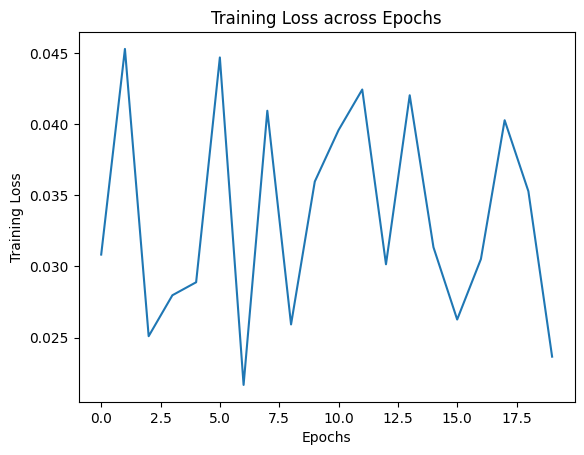

In [51]:
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss across Epochs')
plt.show()

In [52]:
### Train SVM ###
def train_svm(train_data, train_labels):
    x_train, x_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.20, random_state=0)
    svm_classifier = svm.SVC(kernel='rbf', probability=True)
    svm_classifier.fit(x_train, y_train)

    test_pred = svm_classifier.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_test, test_pred)}')

    return svm_classifier

train_dataset = TrainDataset(dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
print('Loading Encoder Model...')
encoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_DANA.pt').to(device)
encoder.eval()

encoded_data = []
labels = []

print('Encoding Data...')
with torch.no_grad():
    for batch in train_dataloader:
        X_batch, y_batch = batch
        X = X_batch.to(device)
        y = y_batch.to(device).reshape(-1, 1)

        encoded_batch = encoder(X)
        # print(encoded_batch.shape)

        ### for unidirectional LSTM ###
        # encoded_batch = encoded_batch.reshape(encoded_batch.shape[1], encoded_batch.shape[2])

        ### bidirectional LSTM have hidden states in 2 dimensions ###
        # h_1, h_2 = encoded_batch[0], encoded_batch[1]
        # encoded_batch = torch.cat((h_1, h_2), 1)
        
        encoded_data.append(encoded_batch)
        labels.append(y)

    encoded_data = torch.cat(encoded_data, 0).cpu()
    labels = torch.cat(labels, 0).cpu()       

print("Training SVM Classifier...")
svm_classifier = train_svm(encoded_data, labels.ravel())
print(labels)

# Save SVM Classifier
with open(f'ML_Models/{dataset_ver}_{encoder_ver}_DANA_svm_classifier.pkl', "wb") as file:
    pickle.dump(svm_classifier, file)

Loading Encoder Model...
Encoding Data...
Training SVM Classifier...
Accuracy: 0.873083475298126
tensor([[2.],
        [1.],
        [0.],
        ...,
        [2.],
        [3.],
        [3.]])


In [53]:
### Test SVM + Encoder ###

# Model Params
encoder_ver = f'{n_hidden}h{num_epochs}e'
test_dataset = TestDataset(dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Load the saved models
autoencoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_DANA.pt')
with open(f'ML_Models/{dataset_ver}_{encoder_ver}_DANA_svm_classifier.pkl', 'rb') as file:
    svm_classifier = pickle.load(file)

autoencoder.eval()

all_inputs = []
all_outputs = []

for batch in test_dataloader:
    X_batch, y_batch = batch
    X = X_batch.to(device)

    with torch.no_grad():
        encoded_batch = autoencoder(X)
        # print(encoded_batch.shape)
        
        ### for unidirectional LSTM ###
        # encoded_batch = encoded_batch.reshape(encoded_batch.shape[1], encoded_batch.shape[2])
        
        ### bidirectional LSTM have hidden states in 2 dimensions ###
        # h_1, h_2 = encoded_batch[0], encoded_batch[1]
        # encoded_batch = torch.cat((h_1, h_2), 1)
        
        predictions = svm_classifier.predict(encoded_batch.cpu())
    all_inputs.append(X.cpu().numpy())
    all_outputs.append(predictions)

# Concatenate the inputs and outputs
all_inputs = np.concatenate(all_inputs)
all_outputs = np.concatenate(all_outputs)

In [54]:
print(all_inputs.shape, all_outputs.shape)
print(x_train.shape, x_test.shape)

(4403, 60, 9) (4403,)
(17609, 60, 10) (4403, 60, 10)


Accuracy: 35.02%


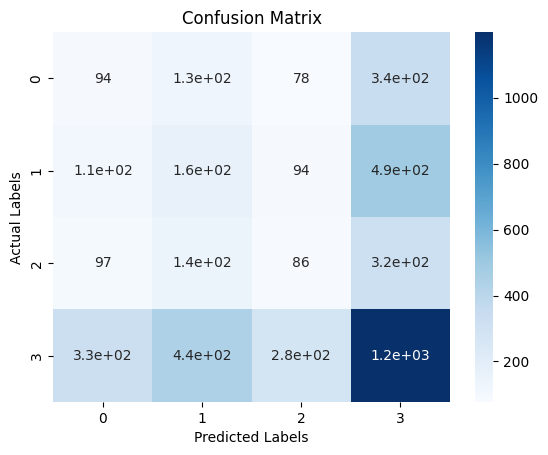

In [55]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, all_outputs)
accuracy_percentage = accuracy * 100
print(f"Accuracy: {accuracy_percentage:.2f}%")

# Create a confusion matrix
cm = confusion_matrix(y_test, all_outputs)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels and title to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()